In [1]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, GlobalAveragePooling1D
from keras.layers import Flatten, Dot
from keras.layers.embeddings import Embedding
from keras.models import Model
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import pickle, random

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/j/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py

# Process and Visualize Embeddings

### Load Preprocessed Data and GloVe Embedding Matrix

In [2]:
padded_docs = np.load('../preprocessing/padded_docs.npy')
padded_labels = np.load('../preprocessing/padded_docs_labels.npy')
pair_labels = np.load('../preprocessing/pair_labels.npy')
pair_idx = np.load('../preprocessing/pairs_idx.npy')

embedding_matrix = np.load('../preprocessing/glov_emb_matrix.npy')

print('Padded Docs:', padded_docs.shape)
print('Padded Labels:', padded_labels.shape)
print('Pair Labels:', pair_labels.shape)
print('Pair Idx Matches:', pair_idx.shape)
print('Embedding Matrix:', embedding_matrix.shape)

input_length = 10000
vocab_size = 544698

Padded Docs: (3037, 10000)
Padded Labels: (3037,)
Pair Labels: (264916,)
Pair Idx Matches: (264916, 2)
Embedding Matrix: (544698, 100)


### GloVe Embedding Model with 1D Global Average Pooling

In [3]:
# sole glov model
input_tens = Input(shape=(input_length,), name='input_1')
x = Embedding(
    vocab_size, 
    100, 
    input_length=input_length, 
    weights=[embedding_matrix],
    trainable=False
)(input_tens)
#x = Flatten()(x)
x = GlobalAveragePooling1D()(x)

model = Model(inputs=input_tens, outputs=x)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10000, 100)        54469800  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
Total params: 54,469,800
Trainable params: 0
Non-trainable params: 54,469,800
_________________________________________________________________


### Predict Embeddings for all Works

In [4]:
embeddings = model.predict(padded_docs, verbose=1)
print('Embeddings:', embeddings.shape)

3037/3037 [==============================] - 11s 4ms/step
Embeddings: (3037, 100)


### UMAP Embeddings for Visualization

In [5]:
umap = UMAP(n_neighbors=20, metric='cosine')
vis_embeddings = umap.fit_transform(embeddings)
print('Vis Embeddings:', vis_embeddings.shape)

Vis Embeddings: (3037, 2)


In [6]:
author_df = pd.read_csv('../preprocessing/author_label_df.csv')
author_df.head(10)

author  label
0                  Isaac_Asimov      0
1                    Mark_Twain      1
2  Sir_William_Schwenck_Gilbert      2
3                Charles_Darwin      3
4                      Eugene_O      4
5            Edward_Stratemeyer      5
6           Henry_David_Thoreau      6
7          William_Butler_Yeats      7
8                Jonathan_Swift      8
9    Elizabeth_Barrett_Browning      9

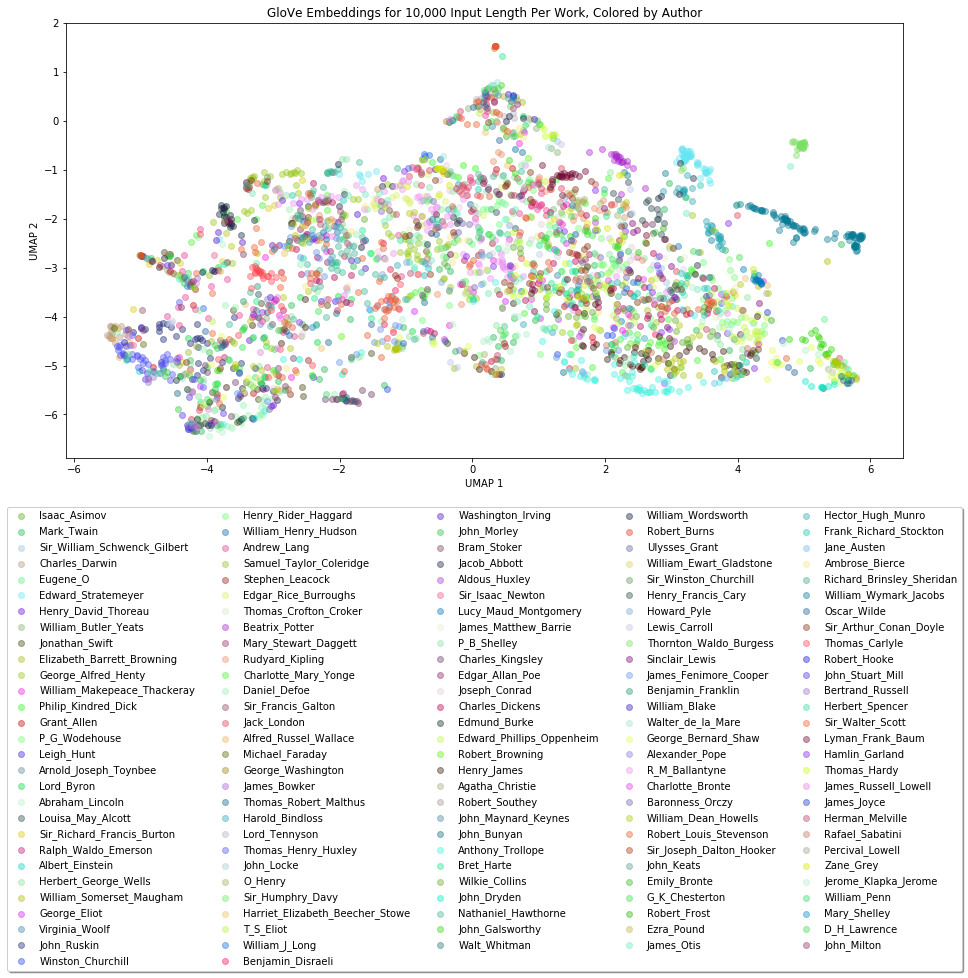

In [7]:
fig = plt.figure(figsize=(15,8))
uniq_labels = np.unique(padded_labels)
for label in uniq_labels:
    author = author_df.loc[author_df['label'] == label, 'author'].values[0]
    label_idx = np.argwhere(padded_labels == label)
    sub_vis_embeddings = vis_embeddings[label_idx, :]
    sub_vis_embeddings = sub_vis_embeddings.reshape(
        sub_vis_embeddings.shape[0]*sub_vis_embeddings.shape[1],
        sub_vis_embeddings.shape[2]
    )
    plt.scatter(
        sub_vis_embeddings[:, 0], 
        sub_vis_embeddings[:, 1], 
        c=np.random.rand(1,3), 
        label=str(author), 
        alpha=0.4
    )

plt.title('GloVe Embeddings for 10,000 Input Length Per Work, Colored by Author')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [8]:
author_label_df = pd.read_csv('../preprocessing/author_work.csv')
author_label_df['umap_1'] = vis_embeddings[:, 0]
author_label_df['umap_2'] = vis_embeddings[:, 1]
author_label_df.head(10)

author_id_label        author  \
0                0  Isaac_Asimov   
1                1    Mark_Twain   
2                1    Mark_Twain   
3                1    Mark_Twain   
4                1    Mark_Twain   
5                1    Mark_Twain   
6                1    Mark_Twain   
7                1    Mark_Twain   
8                1    Mark_Twain   
9                1    Mark_Twain   

                                              work    umap_1    umap_2  
0                                            Youth  3.245549 -3.153641  
1                            Tom_Sawyer,_Detective  3.805649 -2.632964  
2                                      Roughing_It -2.304495 -5.275191  
3                                   A_Tramp_Abroad -1.840983 -4.047492  
4                             Is_Shakespeare_Dead? -3.156459 -4.448061  
5                                Christian_Science -2.923925 -5.313544  
6              Fenimore_Cooper's_Literary_Offences -2.565511 -4.161531  
7                 On_the_Decay_of_the_Art_of_Lying -1.331085 -5.389649  
8                Life_On_The_Mississippi,_Complete -1.393528 -1.724738  
9  Personal_Recollections_of_Joan_of_Arc,_Volume_1 -0.386996 -2.960149

### Plotly Interactive Scatter Plot

In [9]:
fig = px.scatter(author_label_df, x='umap_1', y='umap_2', color='author',
                 hover_data=['work'])
fig.show()

# Nearest Neighbors for Works

### Neighbors Search on 100-D Embeddings

In [15]:
# build data frame with neighbor, author, work
neighbors = NearestNeighbors(n_neighbors=11, metric='cosine').fit(embeddings)
distances, inds = neighbors.kneighbors(embeddings)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = author_label_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
df_neighbors.head(20)
#df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

Query_Title            Query_Author  \
0    Experimental_Researches_in_Electricity,_Volume_1         Michael_Faraday   
1                                           Socialism        John_Stuart_Mill   
2                      Historical_Lectures_and_Essays        Charles_Kingsley   
3                              Madam_How_and_Lady_Why        Charles_Kingsley   
4                                    Mistress_Wilding         Rafael_Sabatini   
5   The_Editor's_Relations_With_The_Young_Contributor    William_Dean_Howells   
6            The_Lay-Man's_Sermon_upon_the_Late_Storm            Daniel_Defoe   
7                            The_Rover_Boys_on_a_Tour      Edward_Stratemeyer   
8                          Colonel_Thorndyke's_Secret     George_Alfred_Henty   
9                 Odd_Man_Out,_Sailor's_Knots,_Part_6   William_Wymark_Jacobs   
10                                The_Woggle-Bug_Book        Lyman_Frank_Baum   
11                                       Jacob's_Room          Virginia_Woolf   
12                                     By_Sheer_Pluck     George_Alfred_Henty   
13                  Lincoln's_First_Inaugural_Address         Abraham_Lincoln   
14                  Cetywayo_and_his_White_Neighbours     Henry_Rider_Haggard   
15                                  The_Clyde_Mystery             Andrew_Lang   
16                             Through_the_Magic_Door  Sir_Arthur_Conan_Doyle   
17                                   Beric_the_Briton     George_Alfred_Henty   
18                             Under_the_Liberty_Tree              James_Otis   
19                                The_Young_Colonists     George_Alfred_Henty   

                                      1st_Match_Title  \
0                                           Darwinism   
1         Considerations_on_Representative_Government   
2   Henry_Esmond;_The_English_Humourists;_The_Four...   
3                Captain_Stormfield's_Visit_to_Heaven   
4                                   The_Tavern_Knight   
5                              Essays_on_Paul_Bourget   
6                                        Areopagitica   
7                  The_Rover_Boys_in_the_Land_of_Luck   
8                                  Rujub,_the_Juggler   
9                   Easy_Money,_Night_Watches,_Part_9   
10                                   The_Four_Million   
11                            Stories_of_Red_Hanrahan   
12                                The_Young_Colonists   
13                      The_Right_To_Ignore_The_State   
14                             Six_Months_at_the_Cape   
15                                    Custom_and_Myth   
16                The_Art_of_Writing_and_Other_Essays   
17                                     For_the_Temple   
18               The_Minute_Boys_of_the_Mohawk_Valley   
19                                 The_Great_Boer_War   

               1st_Match_Author  \
0         Alfred_Russel_Wallace   
1              John_Stuart_Mill   
2   William_Makepeace_Thackeray   
3                    Mark_Twain   
4               Rafael_Sabatini   
5                    Mark_Twain   
6                   John_Milton   
7            Edward_Stratemeyer   
8           George_Alfred_Henty   
9         William_Wymark_Jacobs   
10                      O_Henry   
11         William_Butler_Yeats   
12          George_Alfred_Henty   
13              Herbert_Spencer   
14               R_M_Ballantyne   
15                  Andrew_Lang   
16       Robert_Louis_Stevenson   
17          George_Alfred_Henty   
18                   James_Otis   
19       Sir_Arthur_Conan_Doyle   

                                      2nd_Match_Title       2nd_Match_Author  \
0   On_the_Origin_of_Species_by_Means_of_Natural_S...         Charles_Darwin   
1                                            New_York  James_Fenimore_Cooper   
2                                    Oliver_Goldsmith      Washington_Irving   
3            Some_Rambling_Notes_of_an_Idle_Excursion             Mark_Twain   
4     

### Neighbors Search on UMAP Embeddings, Euclidean Metric

In [11]:
umap_embs = author_label_df[['umap_1', 'umap_2']].values.tolist()
neighbors = NearestNeighbors(n_neighbors=11, metric='euclidean').fit(umap_embs)
distances, inds = neighbors.kneighbors(umap_embs)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = author_label_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(30)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

Query_Title           Query_Author  \
1745                                yo             Bret_Harte   
0                                Youth           Isaac_Asimov   
1370                             Youth          Joseph_Conrad   
83           Young_Hunters_of_the_Lake     Edward_Stratemeyer   
856       Young_Folks'_History_of_Rome   Charlotte_Mary_Yonge   
890    Young_Folks'_History_of_England   Charlotte_Mary_Yonge   
78                   Young_Auctioneers     Edward_Stratemeyer   
2094                You_Never_Can_Tell    George_Bernard_Shaw   
1325                  Yeast:_A_Problem       Charles_Kingsley   
1059                             Yeast    Thomas_Henry_Huxley   
1239                            Xerxes           Jacob_Abbott   
1041                     Wyndham's_Pal        Harold_Bindloss   
2026                         Wyandotte  James_Fenimore_Cooper   
2395                 Wuthering_Heights           Emily_Bronte   
273                     Wulf_the_Saxon    George_Alfred_Henty   
2522                    Write_It_Right         Ambrose_Bierce   
2186            Wrecked_but_not_Ruined         R_M_Ballantyne   
410        Work:_A_Story_of_Experience      Louisa_May_Alcott   
2796       Woodstock;_or,_The_Cavalier       Sir_Walter_Scott   
1144               Wood_Folk_at_School         William_J_Long   
248                   Won_by_the_Sword    George_Alfred_Henty   
3029                     Women_in_Love           D_H_Lawrence   
1326                Women_and_Politics       Charles_Kingsley   
1167  Wolfert's_Roost_and_Miscellanies      Washington_Irving   
1373                  Within_the_Tides          Joseph_Conrad   
1588   Within_the_Rim_and_Other_Essays            Henry_James   
214               With_Wolfe_in_Canada    George_Alfred_Henty   
838                With_The_Night_Mail        Rudyard_Kipling   
224              With_Moore_At_Corunna    George_Alfred_Henty   
265               With_Lee_in_Virginia    George_Alfred_Henty   

                                        1st_Match_Title  \
1745       Lord_Arthur_Savile's_Crime_and_Other_Stories   
0                                   My_Terminal_Moraine   
1370                         The_Heritage_of_the_Desert   
83                                   Guns_And_Snowshoes   
856                                 Alexander_the_Great   
890                                           Charles_I   
78                                   Rollo_in_the_Woods   
2094                              Alice_Sit-By-The-Fire   
1325                                           Phaethon   
1059                        The_Conditions_Of_Existence   
1239                                           Hannibal   
1041                                A_Prairie_Courtship   
2026                                      Dr._Bullivant   
2395                                          Kidnapped   
273                                       The_Fugitives   
2522                                           Heretics   
2186                       The_Relics_of_General_Chasse   
410                                         Money_Magic   
2796                                      Old_Mortality   
1144                            Northern_Trails,_Book_1   
248                        With_Kitchener_in_the_Soudan   
3029                                    A_Monk_of_Cruta   
1326                      Captain_Sword_and_Captain_Pen   
1167              History_of_King_Charles_II_of_England   
1373                                     Moon_of_Israel   
1588                                     Lord_Kitchener   
214                                Richard_of_Jamestown   
838                             Rambles_Beyond_Railways   
224                                    On_the_Irrawaddy   
265   The_Life_and_Adventures_of_Robinson_Crusoe_Of_...   

               1st_Match_Author  \
1745                Oscar_Wilde   
0        Frank_Richard_Stockton   
1370                  Zane_Grey   
83           Edward_Stratemeyer   
856   

### Neighbors Search on UMAP Embeddings, Cosine Metric

In [12]:
umap_embs = author_label_df[['umap_1', 'umap_2']].values.tolist()
neighbors = NearestNeighbors(n_neighbors=11, metric='cosine').fit(umap_embs)
distances, inds = neighbors.kneighbors(umap_embs)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = author_label_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(30)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

Query_Title           Query_Author  \
1745                                yo             Bret_Harte   
0                                Youth           Isaac_Asimov   
1370                             Youth          Joseph_Conrad   
83           Young_Hunters_of_the_Lake     Edward_Stratemeyer   
856       Young_Folks'_History_of_Rome   Charlotte_Mary_Yonge   
890    Young_Folks'_History_of_England   Charlotte_Mary_Yonge   
78                   Young_Auctioneers     Edward_Stratemeyer   
2094                You_Never_Can_Tell    George_Bernard_Shaw   
1325                  Yeast:_A_Problem       Charles_Kingsley   
1059                             Yeast    Thomas_Henry_Huxley   
1239                            Xerxes           Jacob_Abbott   
1041                     Wyndham's_Pal        Harold_Bindloss   
2026                         Wyandotte  James_Fenimore_Cooper   
2395                 Wuthering_Heights           Emily_Bronte   
273                     Wulf_the_Saxon    George_Alfred_Henty   
2522                    Write_It_Right         Ambrose_Bierce   
2186            Wrecked_but_not_Ruined         R_M_Ballantyne   
410        Work:_A_Story_of_Experience      Louisa_May_Alcott   
2796       Woodstock;_or,_The_Cavalier       Sir_Walter_Scott   
1144               Wood_Folk_at_School         William_J_Long   
248                   Won_by_the_Sword    George_Alfred_Henty   
3029                     Women_in_Love           D_H_Lawrence   
1326                Women_and_Politics       Charles_Kingsley   
1167  Wolfert's_Roost_and_Miscellanies      Washington_Irving   
1373                  Within_the_Tides          Joseph_Conrad   
1588   Within_the_Rim_and_Other_Essays            Henry_James   
214               With_Wolfe_in_Canada    George_Alfred_Henty   
838                With_The_Night_Mail        Rudyard_Kipling   
224              With_Moore_At_Corunna    George_Alfred_Henty   
265               With_Lee_in_Virginia    George_Alfred_Henty   

                                      1st_Match_Title  \
1745                                  Rollo_in_Geneva   
0                                        Tommy_and_Co   
1370         The_Luck_of_Roaring_Camp_and_Other_Tales   
83                   The_Rover_Boys_at_Big_Horn_Ranch   
856                               Alexander_the_Great   
890   Letters_of_John_Keats_to_His_Family_and_Friends   
78                             Richard_Dare's_Venture   
2094                                    Caesar's_Wife   
1325                                 I_and_My_Chimney   
1059                                  The_Water-Witch   
1239                                 Orange_and_Green   
1041     For_Better_or_Worse,_Ship's_Company,_Part_10   
2026                                          Opticks   
2395                                  Beyond_the_City   
273                                      The_Monikins   
2522                             With_Wolfe_in_Canada   
2186                                         Marriage   
410                                     Pepper_&_Salt   
2796           Deep_Down,_a_Tale_of_the_Cornish_Mines   
1144    History_of_Friedrich_II_of_Prussia,_Volume_10   
248                             The_Elusive_Pimpernel   
3029                                Songs_Of_The_Road   
1326          Bernard_Shaw's_Preface_to_Major_Barbara   
1167                          Condemned_as_a_Nihilist   
1373                             A_Waif_of_the_Plains   
1588                      Fantasia_of_the_Unconscious   
214                                    Write_It_Right   
838                         Life_of_Cicero_Volume_One   
224                The_Boy_Scouts_in_A_Trapper's_Camp   
265                      The_Dove_in_the_Eagle's_Nest   

              1st_Match_Author  \
1745              Jacob_Abbott   
0         Jerome_Klapka_Jerome   
1370                Bret_Harte   
83          Edward_Stratemeyer   
856               Jacob_Abbott   
890                 John_Keats   
78   